In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importar data

In [2]:
import pandas as pd
import gc
A=pd.read_csv('/content/drive/MyDrive/MIA/MIA-UC-Bimestre 02/Proyecto Aprendizaje No Supervisado/bitacora_BoW.csv', encoding='ISO-8859-1',sep=';',decimal=',')

#Carga y transformacion

In [3]:
D=A.drop(columns=['id bitacora','id atencion',"tipo profesional",'tmp'])

#SVD

In [4]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=D.shape[1]-1)
svd.fit(D)
z=svd.explained_variance_ratio_.cumsum()
cols=svd.feature_names_in_[:-1][z<=z[z>=.8][0]]

#K-MEDOID

In [5]:
!pip install kmedoids

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... error
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... error
     |████████████████████████████████| 354 kB 28.8 MB/s 


##Metodo de Silhouette

In [41]:
import kmedoids as km
import numpy as np
from sklearn.metrics.pairwise import cosine_distances


# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
def silhouete_kmedoids(X,n):
  kmedoids=km.fastpam1(X,n,max_iter=10000)
  return km.silhouette(X,kmedoids.labels)
  
range_n_clusters = np.arange(1,len(cols)-1)+1
diss=cosine_distances(D[cols])
valores_silhouete_kmedoids=np.array(list(map(lambda n:silhouete_kmedoids(diss,int(n)),range_n_clusters)))

N_silhouete_kmedoids=int(range_n_clusters[valores_silhouete_kmedoids.argmax()])
print("cantidad de clusters optimos segun silhouette:",N_silhouete_kmedoids)

cantidad de clusters optimos segun silhouette: 36


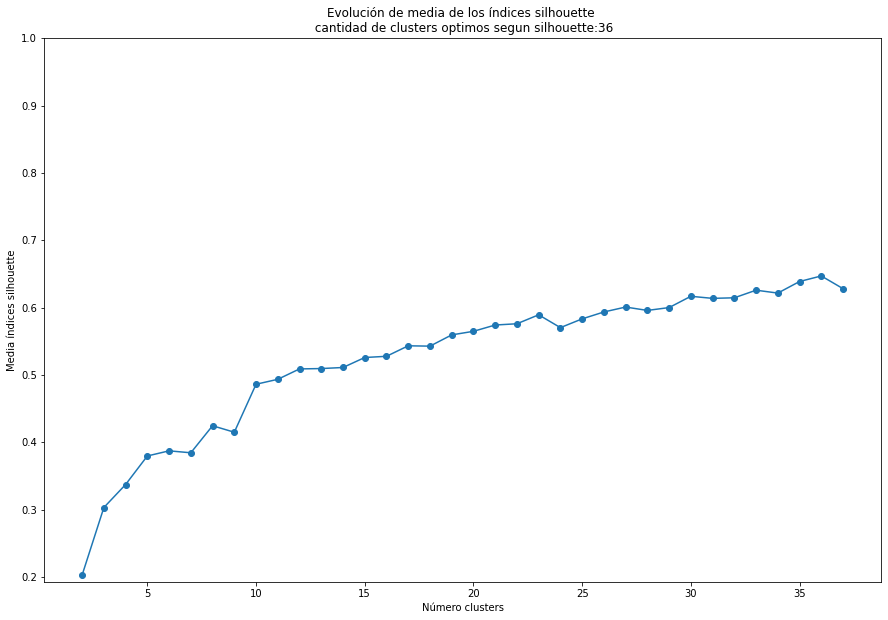

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(range_n_clusters,valores_silhouete_kmedoids, marker='o')
plt.title(f"Evolución de media de los índices silhouette \n cantidad de clusters optimos segun silhouette:{N_silhouete_kmedoids}")
plt.xlabel('Número clusters')
plt.ylabel('Media índices silhouette')
plt.ylim(valores_silhouete_kmedoids.min()-.01, 1)
plt.savefig('/content/drive/MyDrive/MIA/MIA-UC-Bimestre 02/Proyecto Aprendizaje No Supervisado/metodo_silhouete_kmedoids_BoW.png')

###Nube de palabras de los clusters salidos por los metodos de SVD, Silhouette y K-medoids

In [46]:
kmedoids=km.fastpam1(diss,N_silhouete_kmedoids)
y_kmedoids_silhouette=kmedoids.labels

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from google.colab import widgets
a=list(set(y_kmedoids_silhouette))
t = widgets.TabBar(list(map(str,a)))
for j,i in enumerate(a):
  with t.output_to(j):
    DD=D.loc[y_kmedoids_silhouette==i].sum(0)
    df=DD.loc[DD>0]
    wc = WordCloud(background_color="white", max_words=df.size)
    wc.generate_from_frequencies(df.to_dict())
    plt.figure(figsize=(15,10),dpi=int(100*max(15/6.4,10/4.8)))
    plt.imshow(wc)
    plt.axis("off") 
    plt.savefig(f'/content/drive/MyDrive/MIA/MIA-UC-Bimestre 02/Proyecto Aprendizaje No Supervisado/cluster_silouette_{i}_BoW.png')

In [ ]:
pd.concat([A.loc[D.index,['id bitacora','id atencion']],pd.Series(y_kmedoids_silhouette,name='cluster')],axis=1).astype(int).to_csv('/content/drive/MyDrive/MIA/MIA-UC-Bimestre 02/Proyecto Aprendizaje No Supervisado/clusters_silouette_ids_BoW.csv')

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
import numpy as np


# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
def codo_kmedoids(X,n):
  kmedoids = KMedoids(n_clusters=n,metric='cosine')
  kmedoids.fit(X)
  gc.collect()
  return kmedoids.inertia_
  
range_n_clusters = np.arange(D.shape[1])+1

valores_codo_kmedoids=np.array(list(map(lambda n:codo_kmedoids(D,n),range_n_clusters)))
valores_codo_kmedoids/=valores_codo_kmedoids[0]
N_codo_kmedoids=range_n_clusters[(valores_codo_kmedoids<=.2) if any(valores_codo_kmedoids<=.2) else [True]*D.shape[1]][-1]
print("cantidad de clusters optimos segun silhouette:",N_codo_kmedoids)

IndexError: ignored

In [ ]:
N_codo_kmedoids=range_n_clusters[(valores_codo_kmedoids<=.2) if any(valores_codo_kmedoids<=.2) else [True]*D.shape[1]][-1]
print("cantidad de clusters optimos segun silhouette:",N_codo_kmedoids)

cantidad de clusters optimos segun silhouette: 92


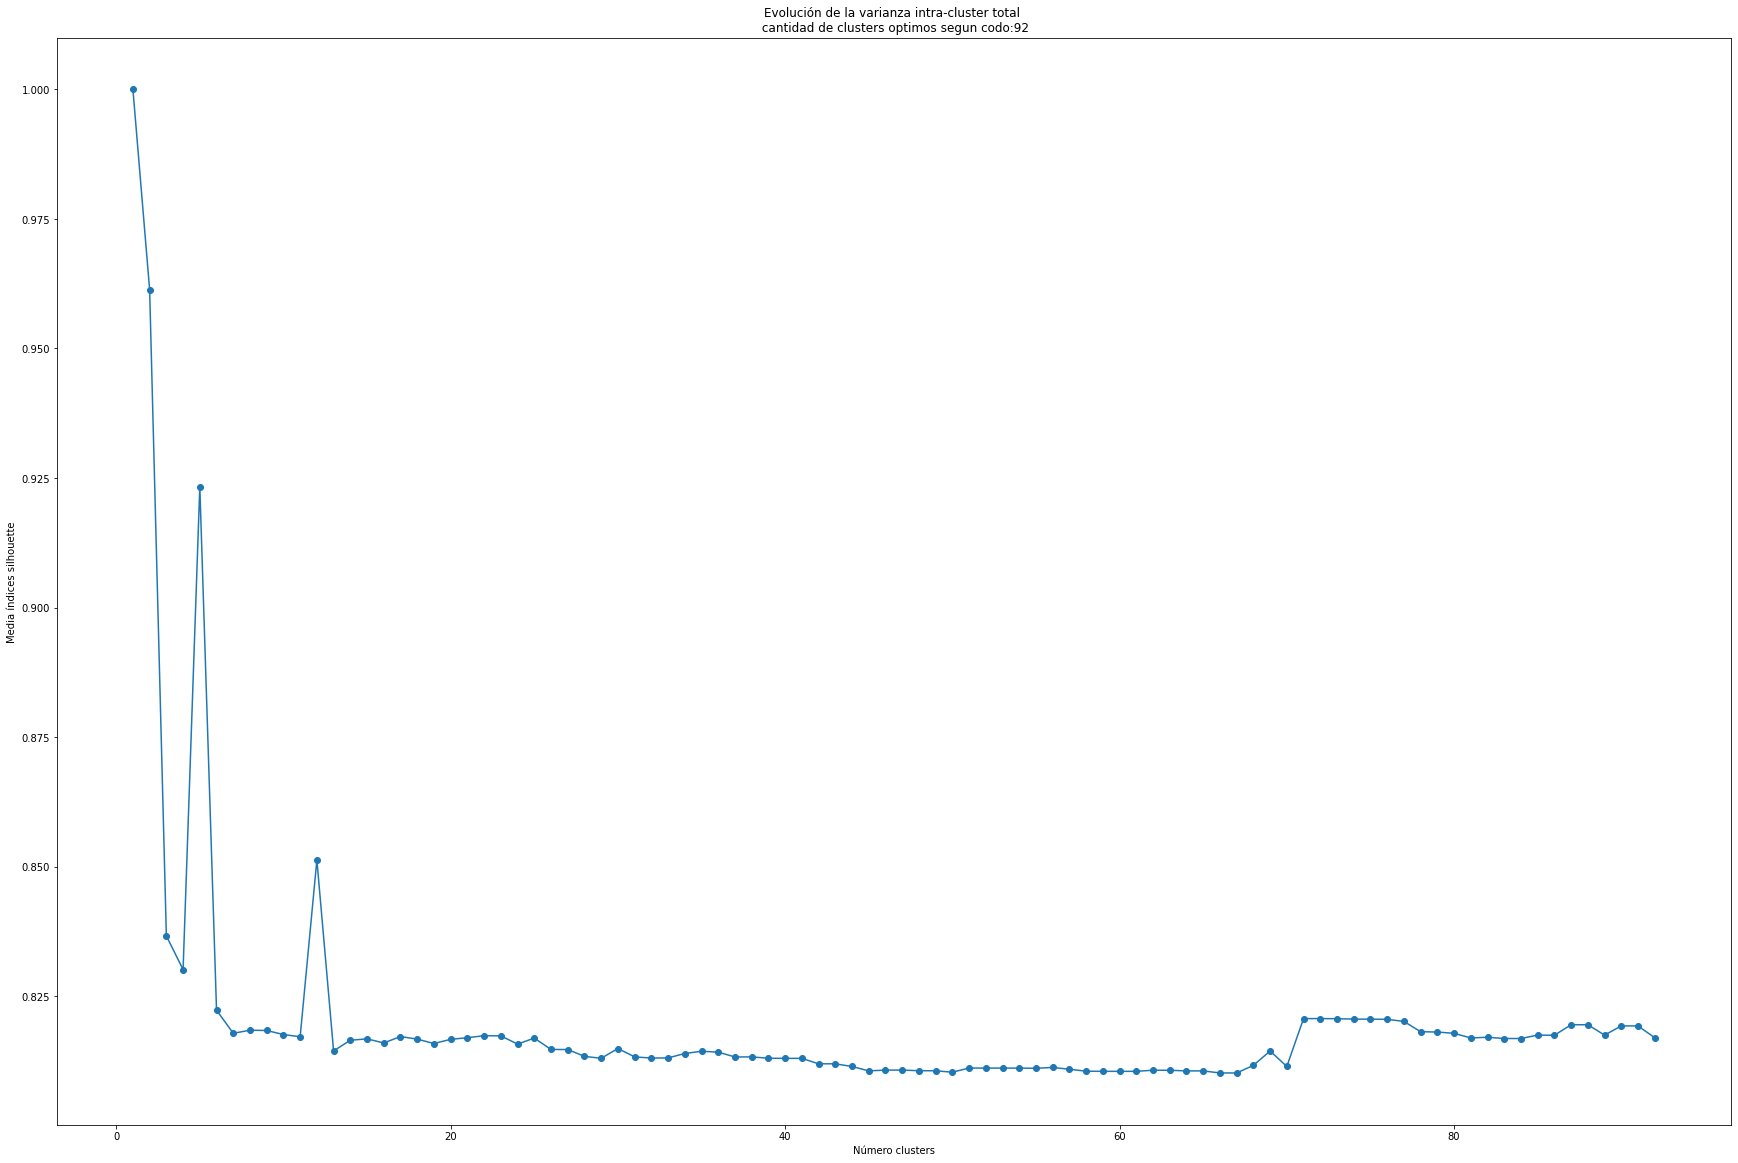

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 20))
plt.plot(range_n_clusters,valores_codo_kmedoids, marker='o')
plt.title(f"Evolución de la varianza intra-cluster total \n cantidad de clusters optimos segun codo:{N_codo_kmedoids}")
plt.xlabel('Número clusters')
plt.ylabel('Media índices silhouette')
plt.ylim(valores_codo_kmedoids.min()-.01, valores_codo_kmedoids.max()+.01)
plt.savefig('/content/drive/MyDrive/MIA/MIA-UC-Bimestre 02/Proyecto Aprendizaje No Supervisado/metodo_codo_kmedoids_BoW.png')

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from google.colab import widgets
a=list(set(y_kmedoids_silhouette))
t = widgets.TabBar(list(map(str,a)))
for j,i in enumerate(a):
  with t.output_to(j):
    DD=D.loc[y_kmedoids_silhouette==i]
    df=DD.loc[(DD!=0).any(1),(DD!=0).any(0)].sum(0)
    wc = WordCloud(background_color="white", max_words=df.size)
    wc.generate_from_frequencies(df.to_dict())
    plt.figure(figsize=(15,10),dpi=300)
    plt.imshow(wc)
    plt.axis("off") 
    plt.savefig(f'/content/drive/MyDrive/MIA/MIA-UC-Bimestre 02/Proyecto Aprendizaje No Supervisado/cluster_codo_{i}_BoW.png')